In [2]:
import numpy as np
import pandas as pd
import contextlib
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
import io

import os
import sys
from joblib import dump,load
from tqdm import tqdm

from experiment_utils import *
home_dir = os.path.abspath("..")  # Move up to the home directory
sys.path.append(home_dir)
from comparator.DOPE.estimators import *
src_path = os.path.abspath("../src")
sys.path.append(src_path)
from models import *
from utils import *

# Suppress R console output
@contextlib.contextmanager
def suppress_r_output():
    r_output = io.StringIO()
    with contextlib.redirect_stdout(r_output), contextlib.redirect_stderr(r_output):
        yield
# Suppress R console output

with suppress_r_output():
    robjects.r['source'](r'../comparator/CollaborativeLearning/models.r')
    run_comparator = robjects.globalenv['run_comparator']

In [3]:
df=pd.read_pickle('../comparator/DOPE/NHANES_removed_original.pkl')
df.columns

Index(['high_pulse_pressure', 'sex_isFemale', 'age', 'physical_activity',
       'serum_albumin', 'alkaline_phosphatase_isUnacceptable',
       'alkaline_phosphatase_isTestnotdone', 'SGOT_isUnacceptable',
       'SGOT_isTestnotdone', 'BUN_isUnacceptable', 'BUN_isTestnotdone',
       'calcium_isUnacceptable', 'calcium_isTestnotdone',
       'creatinine_isUnacceptable', 'creatinine_isTestnotdone',
       'potassium_isUnacceptable', 'sodium_isUnacceptable',
       'total_bilirubin_isUnacceptable', 'total_bilirubin_isTestnotdone',
       'serum_protein', 'red_blood_cells', 'red_blood_cells_isUnacceptable',
       'red_blood_cells_isBlankbutapplicable', 'white_blood_cells',
       'white_blood_cells_isUnacceptable',
       'white_blood_cells_isBlankbutapplicable', 'hemoglobin',
       'hemoglobin_isMissing', 'hematocrit', 'hematocrit_isUnacceptable',
       'hematocrit_isMissing', 'platelets_isNormal', 'platelets_isIncreased',
       'platelets_isDecreased', 'platelets_isNoestimate', 'chole

In [ ]:
# drop missing values of cholesterol
df=df[df['cholesterol_isMissing']==0]
df=df[40<=df['age']]
df=df[df['age']<=65]


df=df.rename(columns={'cholesterol':'y', 'bmi_binary':'A'})

df.drop(['death',
        'cholesterol_isMissing','bmi',], axis=1, inplace=True)

# Suppose df is your DataFrame

# Create an empty dictionary to hold our mapping
rename_mapping = {}
counter = 1

# Loop through the current columns
for col in df.columns:
    # If the column is not 'A' or 'y', add it to the mapping
    if col not in ['A', 'y']:
        rename_mapping[col] = f"X{counter}"
        counter += 1

# Rename the columns in-place
df.rename(columns=rename_mapping, inplace=True)


In [14]:
def estimation(p, df=None, ate=0, #placeholder
                          cross_fit=True, n_folds=5, ps_model='lr',or_model='torch_nn',w_model='kernel_ridge_regression', 
                            random_seed=42, propen_est=True, mu_est=True, stds_return=True, coverage_return=False):

    random.seed(random_seed)

    pandas2ri.activate()

    with suppress_r_output():
        r_df = pandas2ri.py2rpy(df)

    if propen_est:
        ates, stds, df_est = single_trial(
            true_ate=ate, df_full=df, p=p,
            ps_model=ps_model, or_model=or_model,
            w_model=w_model,
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds, stds_return=True,coverage_return=False
        )
        with suppress_r_output():
            r_df = pandas2ri.py2rpy(df_est)
            r_result = run_comparator(df=r_df, p=p, propen_est=propen_est, mu_est=mu_est,random_seed=random_seed)
            result = dict(zip(r_result.names, list(r_result)))
    else:
        with suppress_r_output():
            r_result = run_comparator(df=r_df, p=p, propen_est=propen_est, mu_est=mu_est,random_seed=random_seed)
            result = dict(zip(r_result.names, list(r_result)))

        df['propen'] = result['pi_hat']
        df['mu0'] = result['r0_out']
        df['mu1'] = result['r1_out']

        # Run single trial with results
        ates, stds = single_trial(
            true_ate=ate, df_full=df, p=p,
            ps_model=ps_model, or_model=or_model,
            w_model=w_model,
            random_seed=random_seed, cross_fit=cross_fit, n_folds=n_folds, stds_return=True,coverage_return=False
        )

    # dope
    X_cols = [f"X{i}" for i in range(1, p + 1)]
    ates_dope, vars_dope = SI_IM_cf(T=df['A'].values,Y=df['y'].values, W=df[X_cols].values)

    all_ate = {'true_ate':ate,
                'ate_tmle':result['ate.tmle'][0],
                'ate_ctmle':result['ate.ctmle'][0],
                'ate_cbps':result['ate.cbps'][0],
                'ate_mr':ates['ate_mr'],
                'ate_ipw':ates['ate_ipw'],
                'ate_amr':ates['ate_amr'],
                'ate_aipw':ates['ate_aipw'],
                'ate_siaipw': ates_dope[1],
                'ate_sioapw': ates_dope[2],
                'ate_siobpw': ates_dope[3]}

    all_std = {
                'std_tmle':result['sd.tmle'][0],
                'std_ctmle':result['sd.ctmle'][0],
                'std_cbps':result['sd.cbps'][0],
                'std_mr':stds['ate_mr'],
                'std_ipw':stds['ate_ipw'],
                'std_amr':stds['ate_amr'],
                'std_aipw':stds['ate_aipw'],
                'std_siaipw':np.sqrt(vars_dope[1]),
                'std_sioapw':np.sqrt(vars_dope[2]),
                'std_siobpw': np.sqrt(vars_dope[3])
                }
    return all_ate, all_std, df_est

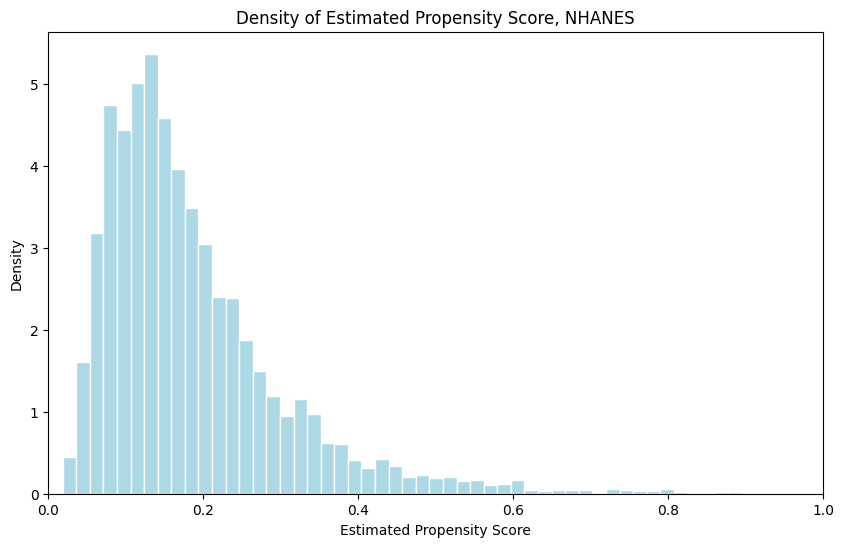

In [ ]:
X_cols = [f"X{i}" for i in range(1, 61+ 1)]
ps_model = LogisticRegression()
ps_model.fit(df[X_cols].values, df['A'].values)
p_train = ps_model.predict_proba(df[X_cols].values)[:, 1]
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Plot the histogram with a fancier color (e.g., lightblue) and add a white edge to each bin
plt.hist(p_train, bins=50, color='lightblue', edgecolor='white', density=True)

# Add the x and y labels
plt.xlabel('Estimated Propensity Score')
plt.ylabel('Density')

# Add a LaTeX-formatted title (you can also use 'coral' for a different color)
plt.title('Density of Estimated Propensity Score, NHANES')

# Set x-axis limits from 0 to 1
plt.xlim(0, 1)

# Display the plot
plt.show()

In [ ]:
ate_results, std_results,df_est = estimation(p=61, df=df, ate=0, #placeholder
                          cross_fit=True, n_folds=5, ps_model='lr',or_model='torch_nn',
                          w_model='kernel_ridge_regression', 
                            random_seed=42, propen_est=True, mu_est=True, stds_return=True, coverage_return=False)


print('ate: ', ate_results)
print('std: ', std_results)

ate:  {'true_ate': 0, 'ate_tmle': 3.410591341069221, 'ate_ctmle': 2.585917952550699, 'ate_cbps': 4.701750453319766, 'ate_mr': 4.369658190618651, 'ate_ipw': 3.8994489878182974, 'ate_amr': 3.4361822682092775, 'ate_aipw': 3.420202428352406, 'ate_siaipw': 230.03241748221572, 'ate_sioapw': 229.8759549997013, 'ate_siobpw': 229.8739293253416}
std:  {'std_tmle': 1.7490423385661873, 'std_ctmle': 1.579939660959257, 'std_cbps': 2.181562080950062, 'std_mr': 9.185053902530791, 'std_ipw': 9.185051891220816, 'std_amr': 1.7473561200810674, 'std_aipw': 1.7473561078703308, 'std_siaipw': 220.18209447265764, 'std_sioapw': 115.652236627838, 'std_siobpw': 115.63574619230386}


In [ ]:
ate_results, std_results,df_est = estimation(p=61, df=df, ate=0, #placeholder
                          cross_fit=True, n_folds=5, ps_model='lr',or_model='lr',
                          w_model='kernel_ridge_regression', 
                            random_seed=42, propen_est=True, mu_est=True, stds_return=True, coverage_return=False)

print('ate: ', ate_results)
print('std: ', std_results)

ate:  {'true_ate': 0, 'ate_tmle': 3.1516283907989475, 'ate_ctmle': 3.8997916698282187, 'ate_cbps': 4.701750453319766, 'ate_mr': 4.369658190618651, 'ate_ipw': 3.8994489878182974, 'ate_amr': 3.5622129570080103, 'ate_aipw': 3.1440033889535304, 'ate_siaipw': 229.79694288170015, 'ate_sioapw': 229.85193950115953, 'ate_siobpw': 229.85047439175028}
std:  {'std_tmle': 1.768828081156364, 'std_ctmle': 1.5738015769044262, 'std_cbps': 2.181562080950062, 'std_mr': 9.185053902530791, 'std_ipw': 9.185051891220816, 'std_amr': 1.7712203418985037, 'std_aipw': 1.771212091123031, 'std_siaipw': 223.0890700748985, 'std_sioapw': 114.07131718709299, 'std_siobpw': 114.05922133441848}


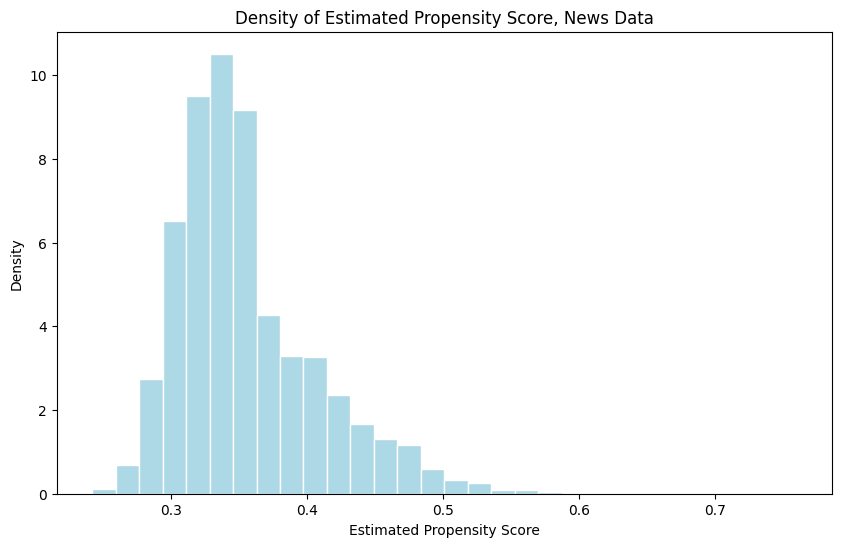

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# Plot the histogram with a fancier color (e.g., lightblue) and add a black edge to each bin
plt.hist(df_est['hat_propen'], bins=30, color='lightblue', edgecolor='white', density = True)

# Add the x and y labels
plt.xlabel('Estimated Propensity Score')
plt.ylabel('Density')

# Add a LaTeX-formatted title (you can also use 'coral' for a different color)
plt.title('Density of Estimated Propensity Score, News Data')

# Display the plot
plt.show()

In [17]:
# sampled_df = df.sample(n=8000, replace=False,random_state=42)
sampled_df = df.sample(n=5000, replace=False,random_state=42)
ate_results, std_results,df_est = estimation(p=62, df=sampled_df, ate=0, #placeholder
                          cross_fit=True, n_folds=5, ps_model='lr',or_model='torch_nn',
                          w_model='kernel_ridge_regression', 
                            random_seed=42, propen_est=True, mu_est=True, stds_return=True, coverage_return=False)

ate_output_file = "results/nhanes/ate_bmi_lr_5000.joblib"
std_output_file = "results/nhanes/std_bmi_lr_5000.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")
print('ate: ', ate_results)
print('std: ', std_results)

Results saved to results/nhanes/ate_bmi_lr_5000.joblib
Results saved to results/nhanes/std_bmi_lr_5000.joblib
ate:  {'true_ate': 0, 'ate_tmle': 0.010115179080809326, 'ate_ctmle': -0.00034120528394776826, 'ate_cbps': -0.0020300010280613497, 'ate_mr': -0.0024693971219731372, 'ate_ipw': -0.002222246911950674, 'ate_amr': -0.00021734129650706322, 'ate_aipw': 0.01304293084368127, 'ate_siaipw': 0.0003185157948277139, 'ate_sioapw': 0.0011420082334251862, 'ate_siobpw': 0.00042376858773825334}
std:  {'std_tmle': 0.009370277426114477, 'std_ctmle': 0.006419858861126274, 'std_cbps': 0.008571739762232553, 'std_mr': 0.008050839697253601, 'std_ipw': 0.008050838938383086, 'std_amr': 0.010180315056381605, 'std_aipw': 0.010178587360186299, 'std_siaipw': 0.6706907808854232, 'std_sioapw': 0.441051378566244, 'std_siobpw': 0.45541523222288577}


In [16]:
# sampled_df = df.sample(n=8000, replace=False,random_state=42)
sampled_df = df.sample(n=5000, replace=False,random_state=42)
ate_results, std_results,df_est = estimation(p=62, df=df, ate=0, #placeholder
                          cross_fit=True, n_folds=5, ps_model='lr',or_model='torch_nn',
                          w_model='kernel_ridge_regression', 
                            random_seed=42, propen_est=True, mu_est=True, stds_return=True, coverage_return=False)

ate_output_file = "results/nhanes/ate_bmi_lr.joblib"
std_output_file = "results/nhanes/std_bmi_lr.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")
print('ate: ', ate_results)
print('std: ', std_results)

Results saved to results/nhanes/ate_bmi_lr.joblib
Results saved to results/nhanes/std_bmi_lr.joblib
ate:  {'true_ate': 0, 'ate_tmle': 0.0037218725102642217, 'ate_ctmle': 0.005599520253479686, 'ate_cbps': 0.00465745899757056, 'ate_mr': 0.0012978344127427426, 'ate_ipw': 0.002518636669344157, 'ate_amr': 0.006566639765068744, 'ate_aipw': 0.003576774683710785, 'ate_siaipw': 0.007207850852827924, 'ate_sioapw': 0.00534964569572897, 'ate_siobpw': 0.0047404352008982445}
std:  {'std_tmle': 0.004748660340792959, 'std_ctmle': 0.0038322728900182816, 'std_cbps': 1.997387672503704, 'std_mr': 0.004438409361372941, 'std_ipw': 0.004438397590111936, 'std_amr': 0.0047857780289706775, 'std_aipw': 0.004785712548359552, 'std_siaipw': 0.507122292891237, 'std_sioapw': 0.4314354479793403, 'std_siobpw': 0.44653530996558594}


In [18]:
# sampled_df = df.sample(n=8000, replace=False,random_state=42)
sampled_df = df.sample(n=5000, replace=False,random_state=42)
ate_results, std_results,df_est = estimation(p=62, df=sampled_df, ate=0, #placeholder
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',
                          w_model='kernel_ridge_regression', 
                            random_seed=42, propen_est=True, mu_est=True, stds_return=True, coverage_return=False)

ate_output_file = "results/nhanes/ate_bmi_nn_5000.joblib"
std_output_file = "results/nhanes/std_bmi_nn_5000.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")
print('ate: ', ate_results)
print('std: ', std_results)

Results saved to results/nhanes/ate_bmi_nn_5000.joblib
Results saved to results/nhanes/std_bmi_nn_5000.joblib
ate:  {'true_ate': 0, 'ate_tmle': 0.05852249014263403, 'ate_ctmle': -0.00034120528394776826, 'ate_cbps': -0.0020300010280613497, 'ate_mr': -0.003414940807441921, 'ate_ipw': 0.1278494972654901, 'ate_amr': -0.0036471582401225093, 'ate_aipw': 0.11027748120492277, 'ate_siaipw': 0.0003185157948277139, 'ate_sioapw': 0.0011420082334251862, 'ate_siobpw': 0.00042376858773825334}
std:  {'std_tmle': 0.028044623453560874, 'std_ctmle': 0.006419858861126274, 'std_cbps': 0.008571739762232553, 'std_mr': 0.05072404825770206, 'std_ipw': 0.05069006127198095, 'std_amr': 0.10523728784646616, 'std_aipw': 0.10522495174305681, 'std_siaipw': 0.6706907808854232, 'std_sioapw': 0.441051378566244, 'std_siobpw': 0.45541523222288577}


In [17]:
# sampled_df = df.sample(n=8000, replace=False,random_state=42)
sampled_df = df.sample(n=5000, replace=False,random_state=42)
ate_results, std_results,df_est = estimation(p=62, df=df, ate=0, #placeholder
                          cross_fit=True, n_folds=5, ps_model='lr',or_model='rf',
                          w_model='kernel_ridge_regression', 
                            random_seed=42, propen_est=True, mu_est=True, stds_return=True, coverage_return=False)

ate_output_file = "results/nhanes/ate_bmi_rf.joblib"
std_output_file = "results/nhanes/std_bmi_rf.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")
print('ate: ', ate_results)
print('std: ', std_results)

Results saved to results/nhanes/ate_bmi_rf.joblib
Results saved to results/nhanes/std_bmi_rf.joblib
ate:  {'true_ate': 0, 'ate_tmle': 0.006221108059653869, 'ate_ctmle': 0.005599520253479686, 'ate_cbps': 0.00465745899757056, 'ate_mr': 0.0012978344127427426, 'ate_ipw': 0.002518636669344157, 'ate_amr': 0.012740458417697676, 'ate_aipw': 0.006267492280971145, 'ate_siaipw': 0.0076215819607599435, 'ate_sioapw': 0.0043533587186969265, 'ate_siobpw': 0.0032774182566774755}
std:  {'std_tmle': 0.004083953594194095, 'std_ctmle': 0.0038322728900182816, 'std_cbps': 1.997387672503704, 'std_mr': 0.004438409361372941, 'std_ipw': 0.004438397590111936, 'std_amr': 0.004085496064819002, 'std_aipw': 0.00408513653070389, 'std_siaipw': 0.5068359204588361, 'std_sioapw': 0.4264316519064298, 'std_siobpw': 0.4494696532240491}


In [ ]:
# sampled_df = df.sample(n=8000, replace=False,random_state=42)

ate_results, std_results,df_est = estimation(p=52, df=df, ate=0, #placeholder
                          cross_fit=True, n_folds=5, ps_model='torch_nn',or_model='torch_nn',
                          w_model='kernel_ridge_regression', 
                            random_seed=42, propen_est=True, mu_est=True, stds_return=True, coverage_return=False)

ate_output_file = "results/nhanes/ate_bmi_nn.joblib"
std_output_file = "results/nhanes/std_bmi_nn.joblib"
os.makedirs(os.path.dirname(ate_output_file), exist_ok=True)
os.makedirs(os.path.dirname(std_output_file), exist_ok=True)
dump(ate_results, ate_output_file)
print(f"Results saved to {ate_output_file}")
dump(std_results, std_output_file)
print(f"Results saved to {std_output_file}")
print('ate: ', ate_results)                 
print('std: ', std_results)

Results saved to results/nhanes/ate_bmi_nn.joblib
Results saved to results/nhanes/std_bmi_nn.joblib
ate:  {'true_ate': 0, 'ate_tmle': -0.04855748276482778, 'ate_ctmle': 0.0062321197862727, 'ate_cbps': 0.007428022625436189, 'ate_mr': 0.004499103526017387, 'ate_ipw': 0.023124974867759777, 'ate_amr': 0.007913763226928213, 'ate_aipw': -0.09638632232019816, 'ate_siaipw': 0.008826414632555239, 'ate_sioapw': 0.005180263256863319, 'ate_siobpw': 0.003409013084137638}
std:  {'std_tmle': 0.01545842462973984, 'std_ctmle': 0.003914007362444813, 'std_cbps': 0.005338522470176181, 'std_mr': 0.014797064518779369, 'std_ipw': 0.014796220102295286, 'std_amr': 0.05507043845300308, 'std_aipw': 0.05506332360656406, 'std_siaipw': 0.5214958202397713, 'std_sioapw': 0.4334308232449892, 'std_siobpw': 0.4623418339735471}
